## Preparation

In [1]:
import math

import matplotlib.pyplot as plt
import copy

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.algorithms.optimizers import COBYLA
import numpy as np
from sklearn import datasets

First we define 2 classes with which we can generate bivariate normal distributions.

We define two different datasets. ```OneClusters``` a distribution containing one bivariate normal distribution. While the ```TwoClusters``` is a distribution consisting of two bivariate normally distributed points.

In [2]:
class OneClusters:

    def __init__(self):
        self.x_mean = 0.75
        self.y_mean = 0.25
        self.std = 0.05

    def generate(self, n):
        data = datasets.make_blobs(n_samples=n * 5, n_features=2, centers=[[self.x_mean, self.y_mean]], cluster_std=self.std)

        data = [[el[0], el[1]] for el in data[0] if 0 < el[0] < 1 and 0 < el[1] < 1]

        data = data[:n]

        return np.array(data)


class TwoClusters:

    def __init__(self):
        self.x1_mean = 0.25
        self.x2_mean = 0.75
        self.y1_mean = 0.75
        self.y2_mean = 0.25
        self.std = 0.05

    def generate(self, n):
        data = datasets.make_blobs(n_samples=n * 5, n_features=2, centers=[[self.x1_mean, self.y1_mean], [self.x2_mean, self.y2_mean]], cluster_std=[self.std, self.std])

        data = [[el[0], el[1]] for el in data[0] if 0 < el[0] < 1 and 0 < el[1] < 1]

        data = data[:n]

        return np.array(data)

We can plot the data in order to inspect it visually.

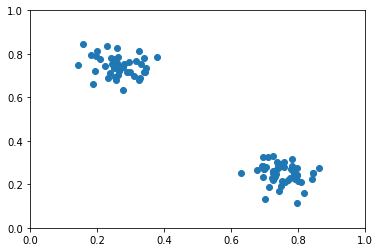

In [3]:
two_clustered_data = TwoClusters().generate(100).transpose()

plt.scatter(two_clustered_data[0], two_clustered_data[1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

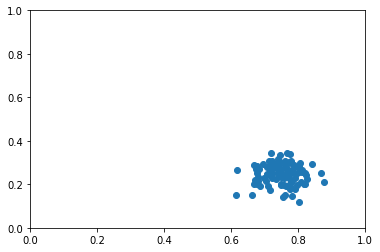

In [4]:
one_clustered_data = OneClusters().generate(100).transpose()

plt.scatter(one_clustered_data[0], one_clustered_data[1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

We then want to generate our datasets for training and initialize some parameters used in training.

In [5]:
one_clustered_data_generator = OneClusters()
two_clustered_data_generator = TwoClusters()

one_clustered_data = one_clustered_data_generator.generate(25000)
two_clustered_data = two_clustered_data_generator.generate(25000)

epochs = 20
alpha = 0.01
steps_per_epoch = 20

## QuGAN Implementation

Define a quantum circuit on which the Discriminator can learn from real samples

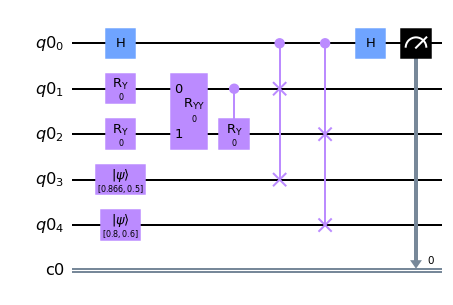

In [6]:
def build_discriminator(d_thetas, real_x, real_y):
    # q0 is for reading result
    # q1, q2 are the discriminator
    # q3, q4 are the real data points
    q = QuantumRegister(5)
    c = ClassicalRegister(1)
    circuit = QuantumCircuit(q, c)

    circuit.initialize([math.sqrt(1 - real_x**2), real_x], 3)
    circuit.initialize([math.sqrt(1 - real_y**2), real_y], 4)

    circuit.h(q[0])

    circuit.ry(d_thetas[0], q[1])
    circuit.ry(d_thetas[1], q[2])

    circuit.ryy(d_thetas[2], q[1], q[2])
    circuit.cry(d_thetas[3], q[1], q[2])

    circuit.cswap(q[0], q[1], q[3])
    circuit.cswap(q[0], q[2], q[4])

    circuit.h(q[0])
    circuit.measure(q[0], c[0])
    
    return circuit

build_discriminator([0, 0, 0, 0], 0.5, 0.6).draw(output='mpl')

Define a quantum circuit on which the Discriminator can learn from generated samples and on which the Generator can learn from discriminated samples.

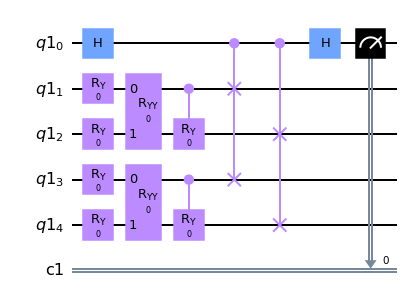

In [7]:
def build_full_circuit(d_thetas, g_thetas):
    # q0 is for reading result
    # q1, q2 are the discriminator
    # q3, q4 are the generator
    q = QuantumRegister(5)
    c = ClassicalRegister(1)
    circuit = QuantumCircuit(q, c)

    circuit.h(q[0])

    circuit.ry(d_thetas[0], q[1])
    circuit.ry(d_thetas[1], q[2])
    circuit.ry(g_thetas[0], q[3])
    circuit.ry(g_thetas[1], q[4])

    circuit.ryy(d_thetas[2], q[1], q[2])
    circuit.ryy(g_thetas[2], q[3], q[4])

    circuit.cry(d_thetas[3], q[1], q[2])
    circuit.cry(g_thetas[3], q[3], q[4])

    circuit.cswap(q[0], q[1], q[3])
    circuit.cswap(q[0], q[2], q[4])

    circuit.h(q[0])
    circuit.measure(q[0], c[0])

    return circuit

build_full_circuit(d_thetas=[0, 0, 0, 0], g_thetas=[0, 0, 0, 0]).draw(output='mpl')

Define a quantum circuit from which we can generate new data points from the Generator.

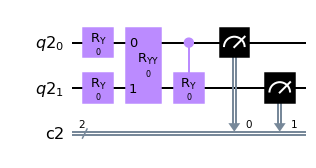

In [8]:
def build_generator(g_thetas):
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    circuit = QuantumCircuit(q, c)

    circuit.ry(g_thetas[0], q[0])
    circuit.ry(g_thetas[1], q[1])

    circuit.ryy(g_thetas[2], q[0], q[1])

    circuit.cry(g_thetas[3], q[0], q[1])

    circuit.measure(q[0], c[0])
    circuit.measure(q[1], c[1])

    return circuit

build_generator([0, 0, 0, 0]).draw(output='mpl')

We define a function with which we can easily run $n$ amount of simulations in order to extract results.

In [9]:
def run_simulation(circuit, shot_count):
    backend = Aer.get_backend('qasm_simulator')
    job = execute(backend=backend, experiments=circuit, shots=shot_count)
    counts = job.result().get_counts()
    prob = counts_to_prob(counts)
    return prob

We then define the derivates and cost functions in order to train the generator.

In [10]:
def derivative(f, theta, epoch):
    return 0.5 * (f * (theta + math.pi / (2 * math.sqrt(epoch + 1))) - f * (theta - math.pi / (2 * math.sqrt(epoch + 1))))

derivatives = np.vectorize(derivative)

def real_cost(circuit):
    runs = 30
    result = run_simulation(circuit, runs)
    result_prob = np.abs(((result / runs) - 0.5) / 0.5)

    if result_prob == 0:
        result_prob = 0.1

    return np.log(result_prob), result

def fake_cost(circuit):
    runs = 30
    result = run_simulation(circuit, runs)
    result_prob = np.abs((result / runs - 0.5) / 0.5)

    if result_prob == 1:
        result_prob = 0.9

    return np.log(1-result_prob), result

Define a function that can convert counts from simulations to points

In [11]:
    def counts_to_prob(counts):
        if '0' in counts.keys():
            x_0 = counts['0']
        else:
            x_0 = 0
        if '1' in counts.keys():
            x_1 = counts['1']
        else:
            x_1 = 0
        return x_1 / (x_0 + x_1)

Next we define a training function which trains our full stack.

In [12]:
def train(data, d_thetas, g_thetas):
    opt_d_thetas, opt_g_thetas, opt_h_dist = d_thetas, g_thetas, 1
    
    d_loss_on_real = []
    d_loss_on_generated = []
    g_loss = []

    for e in range(epochs):
        # First train the Discriminator on real data
        d_real_total_cost = 0
        n_correct = 0
        n_incorrect = 0
        
        # Make a random selection from our dataset
        idx = np.random.randint(len(data), size=steps_per_epoch)
        xs = data[idx]
        # Train the Discriminator on each sample
        for x in xs:
            d_circuit = build_discriminator(d_thetas, x[0], x[1])
            
            # Calculate the cost and gradient
            d_cost, result = real_cost(d_circuit)
            grad = derivatives(d_cost, d_thetas, e)

            # If the result is over 0.5, the discriminator classifies the sample as real.
            if result > 0.5:
                n_correct += 1
            else:
                n_incorrect += 1

            # Update the thetas
            d_thetas -= alpha * grad
            
            # Keep track of the total cost so far
            d_real_total_cost += d_cost

        d_loss_on_real.append(d_real_total_cost)

        d_generated_total_cost = 0
        
        # Then train the Discriminator on the Generator
        for i in range(steps_per_epoch):
            dg_circuit = build_full_circuit(d_thetas, g_thetas)
            
            # Calculate the cost and gradient
            d_cost, result = fake_cost(dg_circuit)
            grad = derivatives(d_cost, d_thetas, e)

            # If the result less than 0.5, the discriminator classifies the sample as fake.
            if result < 0.5:
                n_correct += 1
            else:
                n_incorrect += 1
                
            # Update the thetas
            d_thetas -= alpha * grad

            # Keep track of the total cost so far
            d_generated_total_cost += d_cost

        d_loss_on_generated.append(d_real_total_cost)

        g_total_cost = 0
        # # Finally train the Generator on the Discriminator
        for i in range(steps_per_epoch):
            dg_circuit = build_full_circuit(d_thetas, g_thetas)
            
            # Calculate the cost and gradient
            g_cost, result = fake_cost(dg_circuit)
            g_cost = -g_cost
            grad = derivatives(g_cost, g_thetas, e)

            # Update the thetas
            g_thetas -= alpha * grad

            # Keep track of the total cost so far
            g_total_cost += g_cost
            
        g_loss.append(g_total_cost)
        
        h_dist = calculate_hellinger_distance(true_distribution, calculate_generated_distribution(build_generator(g_thetas)))
        
        # If the Hellinger Distance reaches a new optimal value, update the optimal thetas
        if h_dist < opt_h_dist:
            opt_d_thetas, opt_g_thetas, opt_h_dist = copy.copy(d_thetas), copy.copy(g_thetas), copy.copy(h_dist)
#             print("Updating optimal g_thetas to:", opt_g_thetas)
            
        print(f"Epoch: {e}, G_loss: {g_total_cost:.3f}, D_loss_real: {d_real_total_cost:.3f}, D_loss_gen: {d_generated_total_cost:.3F}, Accuracy D: {n_correct/(n_incorrect + n_correct)}, Hellinger Distance: {h_dist:.3F}")

    return (opt_d_thetas, opt_g_thetas), (d_thetas, g_thetas), (g_loss, d_loss_on_real, d_loss_on_generated)

In order to make an objective assesment of how well the distribution was learned we calculate the Hellinger Distance.

We additionally add a feature when training our model. Since we have an objective evaluation of the performance of the Generator, we will always save the $\theta_g$ which the optimal achieved Hellinger distance. This does not solve the divergence problems however that plague our implementations of the Quantum GANs. The divergence problems need to be solved before the models can be usable outside of toy examples.

We first calculate the true distribution.

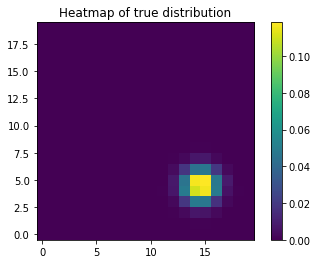

In [13]:
resolution = 0.05

def calculate_true_distribution(data):
    # Initialize values in order to calculate distribution
    # Resolution must divide 1
    xs = np.arange(0, 1, resolution)
    ys = np.arange(0, 1, resolution)
    
    total_data_points = len(data)
    
    probabilities = np.zeros(shape=(int(1/resolution), int(1/resolution)))
    
#     print(data.shape)
#     print(data)
    
    for x_i in range(len(xs)):
        for y_i in range(len(ys)):
            filtered_x = data[((resolution * (x_i + 1) > data[:, 0]) & (data[:, 0] > resolution * x_i))]
            filtered_y = filtered_x[((resolution * (y_i + 1) > filtered_x[:, 1]) & (filtered_x[:, 1] > resolution * y_i))]
            probability = len(filtered_y) / total_data_points
            probabilities[x_i][y_i] = probability
    
    # Transpose the probabilities so that the results represent the data set.
    probabilities = probabilities.T
    
    return probabilities

true_distribution = calculate_true_distribution(one_clustered_data)

plt.imshow(true_distribution)
plt.colorbar()
plt.gca().invert_yaxis()

plt.title("Heatmap of true distribution")

plt.show()

Define a helper function with which we can generate new points from a Generator

In [14]:
def generate_point(g_circuit):
    shots = 30

    backend = Aer.get_backend('qasm_simulator')
    job = execute(backend=backend, experiments=g_circuit, shots=shots)
    result = job.result()

    counts = result.get_counts(g_circuit)

    (x, y) = counts_to_point(counts, shots)

    return x, y

def counts_to_point(counts, shots):
    # For each point: x_i/N where N=shots from generator
    x_0 = 0
    x_1 = 0
    y_0 = 0
    y_1 = 0

    for key in counts.keys():
        if key[0] == '0':
            x_0 += counts[key]
        else:
            x_1 += counts[key]
        if key[1] == '0':
            y_0 += counts[key]
        else:
            y_1 += counts[key]

    return x_1/shots, y_1/shots

Define a function with which we can get the probabilities from the generated distribution.

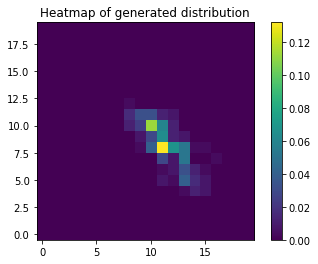

In [18]:
def calculate_generated_distribution(g_circuit):
    # Initialize values in order to calculate distribution
    # Resolution must divide 1
    xs = np.arange(0, 1, resolution)
    ys = np.arange(0, 1, resolution)
    
    total_data_points = 250

    probabilities = np.zeros(shape=(int(1/resolution), int(1/resolution)))
    
    def clamp(n, minn, maxn):
        return max(min(maxn, n), minn)

    for i in range(total_data_points):
        x, y = generate_point(g_circuit)
        # Limit to only valid indices
        probabilities[clamp(int(x / resolution), 0, (int(1/resolution) - 1))][clamp(int(y / resolution), 0, (int(1/resolution) - 1))] += 1/total_data_points
        
    # Transpose the probabilities so that the results represent the data set.
    probabilities = probabilities.T

    return probabilities

g_circuit = build_generator(np.random.random_sample((4,)) * math.pi)
generated_distribution = calculate_generated_distribution(g_circuit)

plt.imshow(generated_distribution)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title("Heatmap of generated distribution")

plt.show()

Now we can define a function with which to calculate the Hellinger Distance.

In [19]:
def calculate_hellinger_distance(true_distribution, generated_distribution):
    result = 0
    
    for x_i in range(len(true_distribution)):
        for y_i in range(len(true_distribution[x_i])):
            result += (math.sqrt(true_distribution[x_i][y_i]) - math.sqrt(generated_distribution[x_i][y_i])) ** 2
            
    return (1 / math.sqrt(2)) * math.sqrt(result)

First intialize the $\theta$'s of the Discriminator and Generator circuits after which we can train the circuit and optimize the parameters.

In [20]:
init_d_thetas = np.random.random_sample((4,)) * math.pi
init_g_thetas = np.random.random_sample((4,)) * math.pi

print("Initial parameters:", init_d_thetas, init_g_thetas)

(opt_d_thetas, opt_g_thetas), (d_thetas, g_thetas), _ = train(one_clustered_data, init_d_thetas, init_g_thetas)
print("Parameters after training:", d_thetas, g_thetas)

Initial parameters: [1.37214046 2.92674156 0.64887449 1.72847835] [2.34481793 1.62785544 3.03817506 1.08518594]
Epoch: 0, G_loss: 72.112, D_loss_real: -0.653, D_loss_gen: -71.112, Accuracy D: 0.5, Hellinger Distance: 0.996
Epoch: 1, G_loss: 77.053, D_loss_real: -0.384, D_loss_gen: -78.692, Accuracy D: 0.5, Hellinger Distance: 1.000
Epoch: 2, G_loss: 69.443, D_loss_real: -0.607, D_loss_gen: -69.439, Accuracy D: 0.375, Hellinger Distance: 1.000
Epoch: 3, G_loss: 72.337, D_loss_real: -0.711, D_loss_gen: -70.945, Accuracy D: 0.6, Hellinger Distance: 0.809
Epoch: 4, G_loss: 92.661, D_loss_real: -0.616, D_loss_gen: -84.588, Accuracy D: 0.65, Hellinger Distance: 0.922
Epoch: 5, G_loss: 73.800, D_loss_real: -0.409, D_loss_gen: -82.975, Accuracy D: 0.525, Hellinger Distance: 1.000
Epoch: 6, G_loss: 66.251, D_loss_real: -0.400, D_loss_gen: -69.205, Accuracy D: 0.25, Hellinger Distance: 1.000
Epoch: 7, G_loss: 71.910, D_loss_real: -0.420, D_loss_gen: -70.252, Accuracy D: 0.325, Hellinger Distance

Unfortunately, with the method implemented from the QuGAN paper, we are not able to optimize the circuit. The Hellinger Distance always stays at a high value.

The function below plots the generators distribution compared to the real distribution.

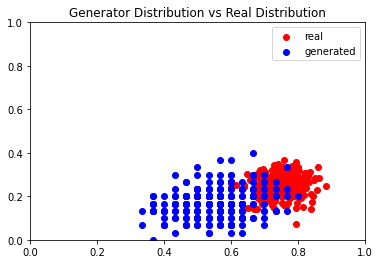

0.8528433029797046

In [21]:
def plot_generator_distribution(g_thetas):
    # First plot the desired distribution
    plt.scatter(*map(list, zip(*one_clustered_data[:250])), color='red', label='real')

    # Plot generated points
    g_circuit = build_generator(g_thetas)
    points = []
    for i in range(250):
        points.append(generate_point(g_circuit))
    plt.scatter(*map(list, zip(*points)), color='blue', label='generated')

    # Plot disc points

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend()

    plt.title("Generator Distribution vs Real Distribution")

    plt.show()

# Plot the optimal g_thetas or the g_thetas produced at the last epoch
# plot_generator_distribution(g_thetas)
plot_generator_distribution(opt_g_thetas)

# Calculate the Hellinger Distance of g_thetas (or opt_g_thetas)
calculate_hellinger_distance(true_distribution, calculate_generated_distribution(build_generator(opt_g_thetas)))

## Adapted Implementation of QuGAN (Adapted structure and cost function)

Our second attempt at implementating the QuGAN uses a more straightforward implementation of a GAN. Where the Discriminator and the Generator are completely separated into two different circuits.

The cost function is changed into a simple calculation of the distance towards a correct prediction.

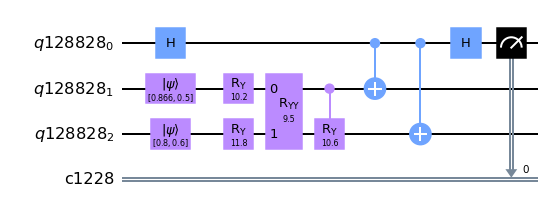

In [22]:
def build_discriminator(d_thetas, real_x, real_y):
    q = QuantumRegister(3)
    c = ClassicalRegister(1)
    circuit = QuantumCircuit(q, c)

    circuit.initialize([math.sqrt(1 - real_x**2), real_x], 1)
    circuit.initialize([math.sqrt(1 - real_y**2), real_y], 2)

    circuit.h(q[0])

    circuit.ry(d_thetas[0], q[1])
    circuit.ry(d_thetas[1], q[2])

    circuit.ryy(d_thetas[2], q[1], q[2])
    circuit.cry(d_thetas[3], q[1], q[2])

    circuit.cnot(q[0], q[1])
    circuit.cnot(q[0], q[2])

    circuit.h(q[0])
    circuit.measure(q[0], c[0])

    return circuit

build_discriminator(init_d_thetas, 0.5, 0.6).draw(output='mpl')

Above we use $q_1$ and $q_2$ to load in the x and y of the data. $q_0$ outputs the judgement of the Discriminator with results near $1$ meaning it evaluates a sample as real and result near $0$ as generated.

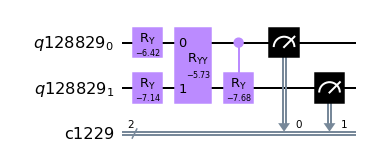

In [23]:
def build_generator(g_thetas):
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    circuit = QuantumCircuit(q, c)

    circuit.ry(g_thetas[0], q[0])
    circuit.ry(g_thetas[1], q[1])

    circuit.ryy(g_thetas[2], q[0], q[1])

    circuit.cry(g_thetas[3], q[0], q[1])

    circuit.measure(q[0], c[0])
    circuit.measure(q[1], c[1])

    return circuit

build_generator(init_g_thetas).draw(output='mpl')

In [24]:
def train(data, d_thetas, g_thetas, epochs=20):
    opt_d_thetas, opt_g_thetas, opt_h_dist = d_thetas, g_thetas, 1
    
    d_loss_on_real = []
    d_loss_on_generated = []
    g_loss = []
    accuracies = []

    # Train for e amount of epochs
    for e in range(epochs):
        d_real_total_cost = 0
        n_correct = 0
        n_incorrect = 0

        # Make a random selection from our dataset
        idx = np.random.randint(len(data), size=steps_per_epoch)
        xs = data[idx]
        # Train the Discriminator on each sample
        for x in xs:
            d_circuit = build_discriminator(d_thetas, x[0], x[1])
            d_prediction = run_simulation(d_circuit, 30)
            d_cost = 1 - d_prediction

            grad = derivatives(d_cost, d_thetas, e)

            # If the result is over 0.5, the discriminator classifies the sample as real.
            if d_prediction > 0.5:
                n_correct += 1
            else:
                n_incorrect += 1

            # Update the thetas
            d_thetas -= alpha * grad

            # Keep track of the total cost so far
            d_real_total_cost += d_cost

        d_loss_on_real.append(d_real_total_cost)

        d_generated_total_cost = 0
        
        # Then train the Discriminator on generated data
        for i in range(steps_per_epoch):
            g_circuit = build_generator(g_thetas)
            (gen_x, gen_y) = generate_point(g_circuit)
            d_circuit = build_discriminator(d_thetas, gen_x, gen_y)
            d_prediction = run_simulation(d_circuit, 30)

            # Calculate the cost and gradient
            d_cost = d_prediction
            grad = derivatives(d_cost, d_thetas, e)

            # If the result less than 0.5, the discriminator classifies the sample as fake.
            if d_prediction < 0.5:
                n_correct += 1
            else:
                n_incorrect += 1

            # Update the thetas
            d_thetas -= alpha * grad

            d_generated_total_cost += d_cost

        d_loss_on_generated.append(d_generated_total_cost)

        g_total_cost = 0
        # # Finally train the Generator on the Discriminator
        for i in range(steps_per_epoch):
            g_circuit = build_generator(g_thetas)
            (gen_x, gen_y) = generate_point(g_circuit)
            d_circuit = build_discriminator(d_thetas, gen_x, gen_y)
            d_prediction = run_simulation(d_circuit, 30)
            
            g_cost = -(1 - d_prediction)
            grad = derivatives(g_cost, g_thetas, e)

            # Update the thetas
            g_thetas -= alpha * grad

            # Keep track of the total cost so far
            g_total_cost += g_cost
        g_loss.append(g_total_cost)

        accuracies.append(n_correct/(n_incorrect + n_correct))
        
        h_dist = calculate_hellinger_distance(true_distribution, calculate_generated_distribution(build_generator(g_thetas)))
        
        # If the Hellinger Distance reaches a new optimal value, update the optimal thetas
        if h_dist < opt_h_dist:
            opt_d_thetas, opt_g_thetas, opt_h_dist = copy.copy(d_thetas), copy.copy(g_thetas), copy.copy(h_dist)
        
        print(f"Epoch: {e}, G_loss: {g_total_cost:.3f}, D_loss_real: {d_real_total_cost:.3f}, D_loss_gen: {d_generated_total_cost:.3F}, Accuracy: {n_correct/(n_incorrect + n_correct)}, Hellinger Distance: {h_dist:.3F}")

    return (opt_d_thetas, opt_g_thetas), (d_thetas, g_thetas), (g_loss, d_loss_on_real, d_loss_on_generated)

In [25]:
init_d_thetas = np.random.random_sample((4,)) * math.pi
init_g_thetas = np.random.random_sample((4,)) * math.pi

print("Initial parameters:", init_d_thetas, init_g_thetas)

(opt_d_thetas, opt_g_thetas), (d_thetas, g_thetas), _ = train(one_clustered_data, init_d_thetas, init_g_thetas)
print("Parameters after training:", d_thetas, g_thetas)

Initial parameters: [0.18051042 0.65166608 3.0207242  1.40082042] [0.99859827 0.24731118 1.97256611 0.00712079]
Epoch: 0, G_loss: -18.067, D_loss_real: 19.600, D_loss_gen: 2.200, Accuracy: 0.5, Hellinger Distance: 0.992
Epoch: 1, G_loss: -18.800, D_loss_real: 19.100, D_loss_gen: 1.033, Accuracy: 0.5, Hellinger Distance: 0.972
Epoch: 2, G_loss: -17.400, D_loss_real: 17.133, D_loss_gen: 1.667, Accuracy: 0.5, Hellinger Distance: 0.885
Epoch: 3, G_loss: -14.133, D_loss_real: 15.200, D_loss_gen: 4.800, Accuracy: 0.5, Hellinger Distance: 0.868
Epoch: 4, G_loss: -11.933, D_loss_real: 14.133, D_loss_gen: 7.833, Accuracy: 0.475, Hellinger Distance: 0.830
Epoch: 5, G_loss: -10.333, D_loss_real: 10.433, D_loss_gen: 8.933, Accuracy: 0.575, Hellinger Distance: 0.835
Epoch: 6, G_loss: -9.967, D_loss_real: 10.667, D_loss_gen: 9.833, Accuracy: 0.375, Hellinger Distance: 0.897
Epoch: 7, G_loss: -10.400, D_loss_real: 9.267, D_loss_gen: 9.833, Accuracy: 0.525, Hellinger Distance: 0.929
Epoch: 8, G_loss: 

We can choose to display the Generator produced at the last epoch or the best Generator we got during the training

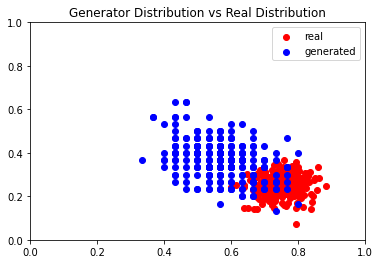

0.8294645173574674

In [26]:
# Plot the optimal g_thetas or the g_thetas produced at the last epoch
# plot_generator_distribution(g_thetas)
plot_generator_distribution(opt_g_thetas)

# Calculate the Hellinger Distance of g_thetas (or opt_g_thetas)
calculate_hellinger_distance(true_distribution, calculate_generated_distribution(build_generator(opt_g_thetas)))

Compared to the non-adapted QuGAN model performs better: In the adapted QuGAN model we can see that the model can learn and converge on the real distribution. However, when trained long enough the model always diverges away from the real distribution.

## Adapted Implementation of QuGAN (Adapted structure and optimization with COBYLA)

We don't have the redefine the ```build_discriminator()``` and ```build_generator()``` functions as we use the same structure as in the other adapted QuGAN implementation.

Since we are using COBYLA however, we must define two objective functions. One for the Discriminator and one for the Generator. (Additionally, we implement this as a class so that we can keep the parameters fixed while training the antagonists)

In [27]:
class QGAN_COBYLA:
    
    def __init__(self, epochs=20):
        self.data_generator = OneClusters()

        self.data = self.data_generator.generate(250)

        self.d_thetas = np.random.random_sample((4,)) * math.pi
        self.g_thetas = np.random.random_sample((4,)) * math.pi
        
        self.opt_d_thetas = copy.copy(self.d_thetas)
        self.opt_g_thetas = copy.copy(self.g_thetas)
        self.opt_h_dist = 1
        
        self.epochs = epochs

        self.alpha = 0.01

        self.steps_per_epoch = 20

    def objective_function_generator(self, g_thetas):
        self.g_thetas = g_thetas
        cost = 0
        for i in range(26):
            (gen_x, gen_y) = self.generate_point()
            d_circuit = build_discriminator(self.d_thetas, gen_x, gen_y)
            prob = run_simulation(d_circuit, 30)
            
            # This cost function can be used to simulate a "perfect" Discriminator in order to see
            # If the Generator can learns distributions without an antagonist
            # cost += abs(0.75 - gen_x) + abs(0.25 - gen_y)

            cost += (1 - prob)

        # print(cost, g_thetas)
        # self.plot_generator_distribution(1)

        return cost

    def objective_function_discriminator(self, d_thetas):
        self.d_thetas = d_thetas
        cost = 0
        for i in range(13):
            (gen_x, gen_y) = self.generate_point()
            d_circuit = build_discriminator(self.d_thetas, gen_x, gen_y)
            prob = run_simulation(d_circuit, 30)

            cost += prob

        idx = np.random.randint(len(self.data), size=13)
        xs = self.data[idx]

        for x in xs:
            d_circuit = build_discriminator(self.d_thetas, x[0], x[1])
            prob = run_simulation(d_circuit, 30)

            cost += (1 - prob)

        return cost
    
    # The training function is defined as follows, where we train the Discriminator and the Generator alternatingly.
    def train(self):
        for i in range(self.epochs):
            optimizer = COBYLA(maxiter=10, tol=0.001)

            opt_param = optimizer.optimize(num_vars=len(self.d_thetas),
                                           objective_function=self.objective_function_discriminator,
                                           initial_point=self.d_thetas)

            self.d_thetas, d_cost, _ = opt_param

            opt_param = optimizer.optimize(num_vars=len(self.g_thetas),
                                           objective_function=self.objective_function_generator,
                                           initial_point=self.g_thetas)

            self.g_thetas, g_cost, _ = opt_param
            
            h_dist = calculate_hellinger_distance(true_distribution, calculate_generated_distribution(build_generator(self.g_thetas)))
            
            # If the Hellinger Distance reaches a new optimal value, update the optimal thetas
            if h_dist < self.opt_h_dist:
                self.opt_d_thetas, self.opt_g_thetas, self.opt_h_dist = copy.copy(self.d_thetas), copy.copy(self.g_thetas), copy.copy(h_dist)
                print("Updating optimal g_thetas to:", self.opt_g_thetas)

            print(f"Epoch {i}, G_cost: {g_cost:.2f}, D_cost: {d_cost:.3f}, Hellinger Distance: {h_dist:.3f}")
            
    def generate_point(self):
        g_circuit = build_generator(self.g_thetas)
        shots = 30

        backend = Aer.get_backend('qasm_simulator')
        job = execute(backend=backend, experiments=g_circuit, shots=shots)
        result = job.result()

        counts = result.get_counts(g_circuit)

        (x, y) = counts_to_point(counts, shots)

        return x, y

In [28]:
QGAN_C = QGAN_COBYLA(20)
print("Initial parameters:", QGAN_C.d_thetas, QGAN_C.g_thetas)

QGAN_C.train()

# data = one_clustered_data
# (opt_d_thetas, opt_g_thetas), (d_thetas, g_thetas), _ = train(init_d_thetas, init_g_thetas)
# print("Parameters after training:", d_thetas, g_thetas)

Initial parameters: [2.73657792 0.16529977 1.09390842 2.50969118] [3.13801857 1.98256272 2.0518258  1.11114563]
Updating optimal g_thetas to: [2.97327923 0.69022422 1.85846752 1.30489749]
Epoch 0, G_cost: 3.33, D_cost: 8.633, Hellinger Distance: 0.722
Epoch 1, G_cost: 1.90, D_cost: 11.100, Hellinger Distance: 1.000
Updating optimal g_thetas to: [5.39431366 3.23440846 6.0533887  2.21010094]
Epoch 2, G_cost: 1.10, D_cost: 5.833, Hellinger Distance: 0.674
Epoch 3, G_cost: 1.73, D_cost: 11.600, Hellinger Distance: 0.960
Epoch 4, G_cost: 0.67, D_cost: 10.433, Hellinger Distance: 0.986
Epoch 5, G_cost: 12.20, D_cost: 7.833, Hellinger Distance: 1.000
Epoch 6, G_cost: 5.90, D_cost: 8.533, Hellinger Distance: 0.943
Updating optimal g_thetas to: [ 7.11899869  2.58920246 12.34964116  4.89199925]
Epoch 7, G_cost: 0.73, D_cost: 10.033, Hellinger Distance: 0.583
Epoch 8, G_cost: 0.23, D_cost: 11.333, Hellinger Distance: 0.971
Epoch 9, G_cost: 2.63, D_cost: 9.100, Hellinger Distance: 0.975
Epoch 10, 

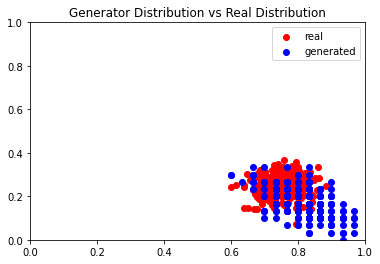

0.6091144154658341

In [29]:
plot_generator_distribution(QGAN_C.opt_g_thetas)

# Calculate the Hellinger Distance of g_thetas (or opt_g_thetas)
calculate_hellinger_distance(true_distribution, calculate_generated_distribution(build_generator(QGAN_C.opt_g_thetas)))

With the COBYLA optimizer we achieve similar results as the Adapted QuGAN without the COBYLA optimizer. The model has a hard time converging, and when it does, it usually diverges quickly.

Saving the best $\theta_g$'s does give us a good approximation of the distribution but does not fix the divergence problem.